# Image Classification Test Model

#### Project Url: https://github.com/akshath/image_classification_kit_keras

In [1]:
#---- Install stuff -------
!pip install --upgrade pip

!pip install opencv-python
!pip install tensorflow
!pip install numpy==1.19.5

!pip install Pillow
!pip install playsound
!pip install gTTS
!pip install pyobjc

!pip install matplotlib
!pip install pandas
!pip install seaborn

!pip install PyYAML

     |████████████████████████████████| 1.7 MB 28.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7037 sha256=6455e971328d31764c963ff1e0b65d60593536e07e112c83381e510c770d0e0e
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound
     |████████████████████████████████| 105 kB 40.0 MB/s            
  Preparing metadata (setup.py) ... error
     |████████████████████████████████| 385 kB 42.7 MB/s            
  Preparing metadata (setup.py) ... error
     |████████████████████████████████| 83 kB 2.2 MB/s             
  Preparing metadata (setup.py) ... error
     |████████████████████████████████| 62 kB 1.3 MB/s             
  Preparing metadata (setup.py) ... error
  Preparing metadata (set

In [2]:
#print system info
import sys
print('Python: ',sys.version)

Python:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [3]:
is_google_colab = True
is_azure_ml = False

In [4]:
 ## If you are using the data by mounting the google drive, use the following :
if is_google_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [5]:
#get path for pycode folder 
if is_google_colab:
  #!ls '/content/gdrive/MyDrive/Colab Notebooks/'
  !ls '/content/gdrive/MyDrive/ColabNotebooks/'

01-ImageClassificationDataCollector.ipynb  project  test_cpu.ipynb
02-ImageClassificationTrainModel.ipynb	   pycode   tools
03-ImageClassificationTestModel.ipynb	   rl-cab
GestureRecognitionProject.ipynb		   temp


In [6]:
#if .py files are in Google Drive
if is_google_colab:

  import sys
  #sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/')
  sys.path.append('/content/gdrive/MyDrive/ColabNotebooks/')

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from datetime import datetime
import random
from glob import glob
import os

In [8]:
import cv2
from PIL import Image

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model

In [10]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [11]:
#print tensor and keras version
print('keras: ', keras.__version__)
print('tensorflow: ', tf.__version__)
import numpy
print('numpy: ', numpy.version.version)

keras:  2.6.0
tensorflow:  2.6.0
numpy:  1.19.5


## Functions

In [12]:
import pycode.FileIOUtil
import pycode.TTSUtil
from pycode.ImageClassificationCfg import ImageClassificationCfg
from pycode.LoadAndTestCNNUtil import LoadAndTestCNNUtil

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [13]:
#function to take pic from webcam on browser for Google Collab kinda env
if is_google_colab:
  from IPython.display import display, Javascript
  from google.colab.output import eval_js
  from base64 import b64decode

  def take_photo_over_webpage(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
    return filename

# Read Cfg

In [14]:
if is_google_colab:
  #locate cfg file in google drive
  !ls '/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/' #change me

cfg.yml  flowers-recognition.json      flowers-recognition.zip
data	 flowers_recognition_model.h5


In [15]:
cfg_file = './project/flowers-recognition/cfg.yml'
#cfg_file = './project/work_pose/cfg.yml'
#cfg_file = './project/home_presence/cfg.yml'

if is_google_colab:
  cfg_file = '/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/cfg.yml' #change me

cfg_file = ImageClassificationCfg(cfg_file)
cfg_file.load()

In [16]:
cfg_file.log_info()

project_name:  flowers-recognition
--------------------
project_parent_dir:  /content/gdrive/MyDrive/ColabNotebooks/project/
project_data_dir:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/
temp_dir:  /content/gdrive/MyDrive/ColabNotebooks/temp/
file_ext:  *.jpg
--------------------
reduce_image_wh_by:  3
crop_image_from_left:  0.0
crop_image_from_right:  0.0
--------------------
project_dir:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/
project_temp_dir: /content/gdrive/MyDrive/ColabNotebooks/temp/flowers-recognition/
loc_unknown: /content/gdrive/MyDrive/ColabNotebooks/temp/flowers-recognition/non-labeled/
--------------------
labels_from_dir:  True
label count:  5
labels: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [17]:
def get_capture_dim(src_video):
    cap = None
    try:
        cap = cv2.VideoCapture(src_video)
        if(cap.isOpened()):
            ret, frame = cap.read()
            return frame.shape
        else:
            return 0,0
    finally:
        if cap!=None:
            cap.release()
        cv2.destroyAllWindows()

In [18]:
#org shape 1080, 1920
capture_dim = get_capture_dim(cfg_file.cfg['src_video'])
print('org dim: ',capture_dim)

img_h = capture_dim[0]
img_w = capture_dim[1]

img_h = img_h//cfg_file.cfg['reduce_image_wh_by']
img_w = img_w//cfg_file.cfg['reduce_image_wh_by']

print('new dim h:',img_h)
print('new dim w:',img_w)

org dim:  (0, 0)
new dim h: 0
new dim w: 0


In [19]:
def plot_image(images, captions=None, cmap=None):    
    if captions!=None:
        print(captions)
    
    if len(images) > 1:
        f, axes = plt.subplots(1, len(images), sharey=True, figsize=(4,4))
        f.set_figwidth(15)
        for ax,image in zip(axes, images):
            ax.imshow(image, cmap)
    else:
        plt.figure(figsize=(4,4))
        plt.imshow(images[0])
    plt.show()

In [20]:
def get_file_name():
    return 'img_'+datetime.now().strftime("%Y%m%d%H%M%S")
#get_file_name()

In [21]:
def capture_frames(cfg_file, crop=True, count=1, delay_sec=60, save=True):
    cap = None
    if img_h==0 or img_w==0:
        raise Exception('img_h or img_w can not be 0')
    try:
        cap = cv2.VideoCapture(cfg_file.cfg['src_video'])
        #cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        
        if(cap.isOpened()):
            for i in range(0, count):
                ret, frame = cap.read()
                if not ret:
                    print("failed to grab frame ")
                    #raise Exception("failed to grab frame ")
                    return None, None

                #print('org shape: ',frame.shape)
                frame = cv2.resize(frame, (img_w,img_h), 
                                   interpolation = cv2.INTER_AREA)

                if crop:
                    if cfg_file.cfg['crop_image_from_left']>0:
                        new_wl = int(img_w*cfg_file.cfg['crop_image_from_left'])
                    else:
                        new_wl = 0
                        
                    if cfg_file.cfg['crop_image_from_right']>0:
                        #crop 70% on width from right
                        new_wr = int(img_w*cfg_file.cfg['crop_image_from_right'])
                    else:
                        new_wr = img_w                    
                        
                    frame = frame[0:img_h,new_wl:new_wr]

                if save:
                    img_name = cfg_file.loc_unknown+"frame_{0}.{1}".format(get_file_name(), cfg_file.cfg['file_ext'][2:])
                    cv2.imwrite(img_name, frame)
                else:
                    img_name = None

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                if count>1 and save:
                    print('file saved: ',img_name)
                    
                if (i+1)!=count:
                    #close and re-open else we will get old frame
                    if cap != None:
                        cap.release()
                    #it take about 2 sec to open cam again
                    if delay_sec>0:
                        time.sleep(delay_sec-2) 
                    cap = cv2.VideoCapture(cfg_file.cfg['src_video'])
                    if(cap.isOpened()==False):
                        print('Could not open camera!')
                        break            
            return frame, img_name
        else:
            print('Could not open camera!')
            return None, None
    finally:
        if cap != None:
            cap.release()
        cv2.destroyAllWindows()

# Load Model

In [22]:
#cfg_file.load() #re-load
cfg_file.cfg['model_file']

'/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/flowers_recognition_model.h5'

In [23]:
cnn = LoadAndTestCNNUtil(cfg_file)
cnn.debug = True
cnn.load()

Loading model file:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/flowers_recognition_model.h5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
___

# Load Test Image

In [24]:
print('project_data_dir: ',cfg_file.project_data_dir)

project_data_dir:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/


In [25]:
all_images = glob(cfg_file.project_data_dir+'*/'+cfg_file.cfg['file_ext'])
print('all img count: ',len(all_images))

all img count:  4317


file:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/daisy/8645839873_0151fb92bf_n.jpg


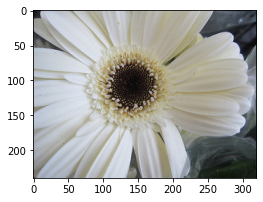

type: <class 'numpy.ndarray'>
shape: (224, 224, 3)
-
Predictions: [[0.17321955 0.30612457 0.14172876 0.24871217 0.13021494]]
Score: tf.Tensor([0.19427045 0.22188434 0.18824804 0.2095042  0.18609302], shape=(5,), dtype=float32)
-
Class: dandelion [ 22.188 %]
-------------------------
   ClassName   Score
1  dandelion  22.188
3  sunflower  20.950
0      daisy  19.427
2       rose  18.825
4      tulip  18.609
-


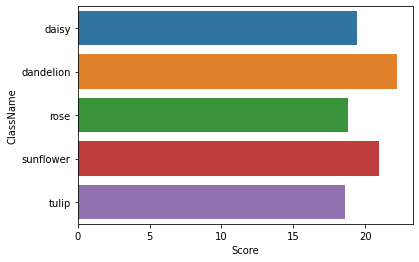

In [28]:
frame = None
file = None

file = random.choice(all_images)
#frame, file = capture_frames(cfg_file=cfg_file,crop=True, count=1, delay_sec=0, save=True)
#file = '/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/sunflower/6133988570_9dc778e622_m.jpg'
if is_google_colab==True and False:
  try:
    file = cfg_file.loc_unknown+"frame_{0}.{1}".format(get_file_name(), cfg_file.cfg['file_ext'][2:])
    take_photo_over_webpage(file)

    frame = cv2.imread(file)
    w = cfg_file.cfg['input_img_width']
    h = cfg_file.cfg['input_img_height']
    frame = cv2.resize(frame, (w,h), interpolation = cv2.INTER_AREA)
    cv2.imwrite(file, frame)
    frame = None
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

print('file: ',file)
if frame is None:
    frame = Image.open(file)

plot_image([frame])

(img_class, model_acc) = cnn.predict(file)

In [29]:
#delete temp file
if file.startswith(cfg_file.loc_unknown):    
    if os.path.isfile(file):
        print('Deleted temp file')
        os.remove(file)
    else:
        #no file to delete
        pass